### Data loading and analysis notebook for Allio Bullet R1 V2 roast data https://aillio.com/
**by Ryan @f.w.Bennies https://www.instagram.com/f.w.bennies/**

<img src="images/allRoastsPlt.png" alt="friends" width="270"/> <img src="images/bulletRoastingEDA.png" alt="friends" width="210"/><img src="images/friendshipsign.png" alt="friends" width="210"/>


#### Objectives
 Automaticaly load, serialize, and combine data from .json files. Then clean up unwanted data (non-standard batches)
 Split into curve and point data, create a few new features
 Summarize and display data (EDA) to enable data driven decisions in planning and real-time roasting

#### Nice to haves:
 impute data (with confidence) rather than remove missing data
 generate additional new features
 incorporate bean density

#### Excluding
 assocation for brewing techniques or results such as taste and aroma
 quantified color changes

*Note: If your RoastTime isn't installed in the default MacOS location, edit 'base_path' (lines ~18-19)*

*Built for my bullet (hardware version) purchased in July 2020 - noteworthy because the data structure of the .json files have changed over time which requires some merges or gap fixes.*

In [1]:
#################################################
## open each .json in folder and append to df  ##
#################################################
import os
from pathlib import Path
import json
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import scipy.stats as stats
pd.set_option('display.max_columns', 55)
plt.style.use('seaborn-colorblind')

# Load from roasTime repository on macOS
home = os.path.expanduser('~')
base_path = os.path.join(home, 'Library/Application Support/roast-time/roasts')
##  IF you have a specific set of roast profiles in another folder, uncomment the below
# base_path = Path('/data')

df = pd.DataFrame()

for entry in os.listdir(base_path):
    full_path =  Path('%s/%s' % (base_path, entry))
    with full_path.open() as f:
        data = json.loads(f.read())
        df_load = pd.json_normalize(data)
    df = pd.concat([df,df_load], ignore_index=True)

# Export the raw DataFrame to a .csv file just for the record
#create subfolder
subfolder = 'csvExports/'
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

df.to_csv(subfolder + f"raw_bullet-roasting_df.csv", index=False)

#############################
##  First basic clean up   ##
#############################

# Sort and remove rows with missing data
df.sort_values(by='dateTime', inplace=True)
df.dropna(subset=['roastName'], inplace=True)

# Filter dataframe to only your User ID

choiceUserID = '73009f59-2d2e-4215-b6ff-961946ee0b80' ## enter specific userID (extracted from .json roast file, or RoastWorld web address)
df = df.query('userId == @choiceUserID and isFork != 1.0')

# Define list of unused data
other_meta = ['userId', 'isFork', 'serialNumber', 'IRSensor', 'inventory.nextGreenWeight',
              'inventory.previousGreenWeight', 'inventory.changeInGreenWeight', 'isPrivate',
             'slug', 'updated_at', 'updatedAt', 'hardware']

# Drop the extra data
df.drop(other_meta, axis=1, inplace = True)
display (df)

beanChargeTemperature  beanDropTemperature  drumChargeTemperature  \
6                    125.9                187.6                  237.7   
104                  150.1                189.8                  244.9   
84                   147.8                202.6                  245.1   
8                    150.0                199.8                  245.3   
102                  158.7                198.9                  247.3   
..                     ...                  ...                    ...   
95                   177.3                206.1                  275.1   
32                   166.1                206.4                  268.7   
73                   174.8                200.6                  260.0   
58                   164.8                201.7                  245.4   
101                  154.7                184.9                  231.9   

     drumDropTemperature                                    beanTemperature  \
6                  204.6  [125.9, 126.1, 126.2, 126.3, 126.4, 126.5, 126...   
104                207.6  [150.1, 150.1, 150.1, 150.1, 150.2, 150.2, 150...   
84                 216.1  [147.8, 148, 148.1, 148.3, 148.4, 148.5, 148.6...   
8                  208.6  [150, 150.1, 150.2, 150.3, 150.5, 150.6, 150.6...   
102                211.0  [158.7, 158.8, 159, 159.2, 159.3, 159.5, 159.5...   
..                   ...                                                ...   
95                 211.0  [177.3, 177.3, 177.3, 177.3, 177.3, 177.2, 177...   
32                 210.4  [166.1, 166, 165.9, 165.7, 165.6, 165.4, 165.3...   
73                 211.2  [174.8, 174.7, 174.7, 174.6, 174.5, 174.5, 174...   
58                 213.7  [164.8, 164.9, 164.9, 164.9, 165, 165, 165, 16...   
101                204.6  [154.7, 154.7, 154.7, 154.7, 154.7, 154.7, 154...   

                                       drumTemperature  \
6    [237.7, 237.6, 237.9, 238, 237.3, 25, 25, 25, ...   
104  [244.9, 245.1, 244.8, 244.6, 243.9, 25, 25, 25...   
84   [245.1, 245.7, 245.6, 245.1, 245, 25, 25, 25, ...   
8    [245.3, 244.9, 244.9, 243.7, 243.5, 25, 25, 25...   
102  [247.3, 247.2, 247, 246.5, 245.3, 25, 25, 25, ...   
..                                                 ...   
95   [275.1, 275.3, 275.1, 275.3, 274.4, 25, 25, 25...   
32   [268.7, 269.1, 269.1, 268.6, 267.1, 266.1, 25,...   
73   [260, 260.1, 260.1, 260.2, 259.9, 25, 25, 25, ...   
58   [245.4, 245.2, 244.9, 244.9, 244.9, 25, 25, 25...   
101  [231.9, 232.1, 231.8, 231.8, 231.3, 25, 25, 25...   

                                        beanDerivative  \
6    [18.7, 17.6, 16.1, 14.3, 12.8, 11, 7, -0.9, -1...   
104  [2.6, 2.8, 2.6, 2.2, 1.2, -0.4, -4.4, -11.5, -...   
84   [19.7, 19, 18.7, 18.2, 16.6, 14.4, 11.3, 5.9, ...   
8    [16.6, 15.8, 15.8, 15.4, 14.5, 6.9, 6.9, -0.8,...   
102  [21.8, 21.5, 20.7, 19.9, 18.7, 14.8, 7.4, -3.6...   
..                                                 ...   
95   [2.4, 1.4, -0.4, -1.8, -2.6, -9.3, -17.9, -30....   
32   [-15.9, -16.5, -16.9, -17.8, -18.4, -18.1, -17...   
73   [-9, -8.9, -8.4, -7.9, -7.9, -9.6, -14.6, -23....   
58   [2.2, 2.6, 3.4, 4.2, 4.7, 3.6, -2.2, -11.3, -2...   
101  [0, -0.1, 0, 0.1, -0.2, -4.4, -10.8, -20.7, -3...   

                                        ibtsDerivative  \
6                                                   []   
104                                                 []   
84                                                  []   
8                                                   []   
102                                                 []   
..                                                 ...   
95   [-18, 0, 6, -6, 6, -27, -7482, 0.6, 0.6, 3.2, ...   
32   [12, -6, 12, 0, -15, -45, -30, 0.2, 0.2, 2, 2,...   
73   [-3, -12, 3, 0, 3, -9, -7047, 0.2, 0.2, 1.7, 1...   
58   [-9, 6, -6, -9, 0, 0, -6597, 0.6, 0.6, 2.7, 2....   
101  [-9, -3, 6, -9, 0, -15, -6189, 0.8, 0.8, 3.2, ...   

                                       exitTemperature  preheatTemperature  

In [2]:
## This is where I may put a LOAD from the outside .py file

In [13]:
#############################
# Clean up and Enrich data  #
#############################
try:
    # change dtypes
    dtype_cols = ['weightGreen','weightRoasted','ambient', 'humidity', 'ambientTemp','roomHumidity']
    df[dtype_cols] = df[dtype_cols].apply(pd.to_numeric, errors='coerce')

    # combine RT2 ambientTemp and roomHumidity with RT3 ambient and humidity (note I am using ambient F)
    ambientMeasurement = 'F'  #or C

    df.loc[df['ambient'].isna(), 'ambient'] = df['ambientTemp'].astype(float)
    df.loc[df['humidity'].isna(), 'humidity'] = df['roomHumidity'].astype(float)
    df.drop(columns=['ambientTemp', 'roomHumidity','exitTemperature'], inplace =  True)  #dropping old environmental data and exitTemp

    ###OPPORTUNITY to impute ambient temp where missing##
    df.ambient.replace(to_replace = 0.0, value = np.nan, inplace = True) # some case of temp actually being 0.0 C or F will be excluded, but needed to remove outliers
except KeyError:
    print("Columns missing in repeated runs, skipping execution.")

    # convert dateTime
    df['dateTime'] = pd.to_datetime(df['dateTime'], unit='ms')

# Calculate -> weight lost percent = 100 * (green - roasted)/ green #   PLUS OTHERS
df['weightLostPercent'] = 100 * (df['weightGreen'] - df['weightRoasted']) / df['weightGreen']
df.loc[df['weightLostPercent'] > 17, 'weightLostPercent'] = np.nan  ## Future change to 50, 17 is too low

# Fix low and high pre-heat errors (replace drumChargeTemperature w/ PH temp when z value > 3)
# May want to edit raw json file if you still have bad preheat temps
#df['drumChargeTemperature'].where(abs(stats.zscore(df.drumChargeTemperature-df.preheatTemperature)) < 3,
#                                  df['preheatTemperature'], inplace = True)

# calulate difference of beanDropTemp and beanChargeTemp (not ITBS, this should relative)   # maybe
df['Drop-ChargeDeltaTemp'] = df['beanDropTemperature'] - df['beanChargeTemperature']

# remove instances where FC was not picked or picked late 
## Would be better to impute FC values in the future
df.loc[(df['indexFirstCrackStart'] > 2400) | (df['indexFirstCrackStart'] == 0), 'indexFirstCrackStart'] = np.nan
df.loc[df['weightRoasted'] < 10, 'weightRoasted'] = np.nan
df.loc[df['weightLostPercent'] > 50, 'weightLostPercent'] = np.nan
    
display (df.head(3))
display (df.tail(3))

Columns missing in repeated runs, skipping execution.


beanChargeTemperature  beanDropTemperature  drumChargeTemperature  \
6                    125.9                187.6                  237.7   
104                  150.1                189.8                  244.9   
84                   147.8                202.6                  245.1   

     drumDropTemperature                                    beanTemperature  \
6                  204.6  [125.9, 126.1, 126.2, 126.3, 126.4, 126.5, 126...   
104                207.6  [150.1, 150.1, 150.1, 150.1, 150.2, 150.2, 150...   
84                 216.1  [147.8, 148, 148.1, 148.3, 148.4, 148.5, 148.6...   

                                       drumTemperature  \
6    [237.7, 237.6, 237.9, 238, 237.3, 25, 25, 25, ...   
104  [244.9, 245.1, 244.8, 244.6, 243.9, 25, 25, 25...   
84   [245.1, 245.7, 245.6, 245.1, 245, 25, 25, 25, ...   

                                        beanDerivative ibtsDerivative  \
6    [18.7, 17.6, 16.1, 14.3, 12.8, 11, 7, -0.9, -1...             []   
104  [2.6, 2.8, 2.6, 2.2, 1.2, -0.4, -4.4, -11.5, -...             []   
84   [19.7, 19, 18.7, 18.2, 16.6, 14.4, 11.3, 5.9, ...             []   

     preheatTemperature  roastStartIndex  roastEndIndex  totalRoastTime  \
6                   240                0           1099             547   
104                 245                0            971             483   
84                  245                0           1031             513   

     indexFirstCrackStart  indexFirstCrackEnd  indexSecondCrackStart  \
6                   880.0                   0                      0   
104                 760.0                   0                      0   
84                  838.0                   0                      0   

     indexSecondCrackEnd  indexYellowingStart  weightGreen  weightRoasted  \
6                      0                  756          370            NaN   
104                    0                  406          380          336.0   
84                     0                  422          490          425.0   

     roastNumber  sampleRate  firmware missingSeconds  rorPreheat  \
6              8           2       562             []         NaN   
104            9           2       562             []         NaN   
84            10           2       562             []         NaN   

                                      uid                dateTime  \
6    56c8ea68-dca0-4ec6-8934-e469744b425d 2020-07-25 01:53:27.716   
104  a455d0a0-23a7-4425-9ce5-950fd97e238e 2020-07-29 00:49:27.878   
84   f9561e80-21de-4d2c-9258-eff0071b8c05 2020-07-31 01:52:38.079   

                       roastName  ambient  humidity  \
6           First Post-seasoning     78.0      90.0   
104     2nd Ethopia Extended Dev      NaN      50.0   
84   First BBP attempt - CItyish      NaN       NaN   

                                   beanId softwareVersion  firmwareVersion  \
6    3105b557-916f-40b6-bec1-59f17c2a8fd7             NaN              NaN   
104  3105b557-916f-40b6-bec1-59f17c2a8fd7             NaN              NaN   
84   3105b557-916f-40b6-bec1-59f17c2a8fd7             NaN              NaN   

    actions.actionTempList                             actions.actionTimeList  \
6                       []  [{'index': 6, 'value': 7, 'ctrlType': 0}, {'in...   
104                     []  [{'index': 6, 'value': 7, 'ctrlType': 0}, {'in...   
84                      []  [{'index': 6, 'value': 7, 'ctrlType': 0}, {'in...   

                                     guid  number rating  \
6    56c8ea68-dca0-4ec6-8934-e469744b425d   983.0      2   
104  a455d0a0-23a7-4425-9ce5-950fd97e238e   984.0      2   
84   f9561e80-21de-4d2c-9258-eff0071b8c05   986.0      2   

                                              comments annotationComments  \
6    First real attempt after seasoning. Several sm...                NaN   
104  Better results to drop temp by increasing fan ...                NaN   
84   First BBP PH try. PH to 260 9 mins + 2 min hol...                NaN   

   

beanChargeTemperature  beanDropTemperature  drumChargeTemperature  \
73                   174.8                200.6                  260.0   
58                   164.8                201.7                  245.4   
101                  154.7                184.9                  231.9   

     drumDropTemperature                                    beanTemperature  \
73                 211.2  [174.8, 174.7, 174.7, 174.6, 174.5, 174.5, 174...   
58                 213.7  [164.8, 164.9, 164.9, 164.9, 165, 165, 165, 16...   
101                204.6  [154.7, 154.7, 154.7, 154.7, 154.7, 154.7, 154...   

                                       drumTemperature  \
73   [260, 260.1, 260.1, 260.2, 259.9, 25, 25, 25, ...   
58   [245.4, 245.2, 244.9, 244.9, 244.9, 25, 25, 25...   
101  [231.9, 232.1, 231.8, 231.8, 231.3, 25, 25, 25...   

                                        beanDerivative  \
73   [-9, -8.9, -8.4, -7.9, -7.9, -9.6, -14.6, -23....   
58   [2.2, 2.6, 3.4, 4.2, 4.7, 3.6, -2.2, -11.3, -2...   
101  [0, -0.1, 0, 0.1, -0.2, -4.4, -10.8, -20.7, -3...   

                                        ibtsDerivative  preheatTemperature  \
73   [-3, -12, 3, 0, 3, -9, -7047, 0.2, 0.2, 1.7, 1...                 260   
58   [-9, 6, -6, -9, 0, 0, -6597, 0.6, 0.6, 2.7, 2....                 245   
101  [-9, -3, 6, -9, 0, -15, -6189, 0.8, 0.8, 3.2, ...                 230   

     roastStartIndex  roastEndIndex  totalRoastTime  indexFirstCrackStart  \
73                 0           1237             616                1044.0   
58                 0           1348             672                1076.0   
101                0           1139             567                 956.0   

     indexFirstCrackEnd  indexSecondCrackStart  indexSecondCrackEnd  \
73                    0                      0                    0   
58                    0                      0                    0   
101                   0                      0                    0   

     indexYellowingStart  weightGreen  weightRoasted  roastNumber  sampleRate  \
73                   536          750          597.3          135           2   
58                   538          650          554.0          135           2   
101                  466          450          387.8          135           2   

     firmware missingSeconds  rorPreheat                    uid  \
73        602             []        30.8  kILl9SjpQK4PPYA3fSiuq   
58        602             []        30.8  C-BlHcng4B3hmJ8pFp3UG   
101       602             []        30.8  56Udx9k2CXkibw5ehLVdu   

                   dateTime  \
73  2023-01-28 16:15:06.747   
58  2023-01-28 17:13:41.661   
101 2023-01-28 18:51:30.766   

                                             roastName  ambient  humidity  \
73           #114 Guatemalan Huehuetenango Coffee Kids     21.0      71.0   
58   #115 Guatemala Huehuetenango Coffee Kids 650g/...     22.6      70.0   
101            #116 Columbia Huila Double Ferment 450g     24.5      64.0   

                   beanId softwareVersion  firmwareVersion  \
73                    NaN           3.4.1            602.0   
58                    NaN           3.4.1            602.0   
101  OclozUsprYAMg7xEdnvz           3.4.1            602.0   

    actions.actionTempList                             actions.actionTimeList  \
73                      []  [{'ctrlType': 0, 'index': 6, 'value': 2}, {'ct...   
58                      []  [{'ctrlType': 0, 'index': 6, 'value': 2}, {'ct...   
101                     []  [{'ctrlType': 0, 'index': 6, 'value': 2}, {'ct...   

    guid  number rating comments annotationComments  roastDegree recipeID  \
73   NaN     NaN    NaN      NaN                NaN          NaN      NaN   
58   NaN     NaN    NaN      NaN                NaN          NaN      NaN   
101  NaN     NaN    NaN      NaN                NaN          NaN      NaN   

     weightLostPercent  Drop-ChargeDeltaTemp  
73                 NaN                  25.8  
58           

In [14]:
######################################################
# deconstruct temp curves from lists to new curve_df #
######################################################
## data for temp and derivative curve of each  is in a single cell as a list ###
# For each roast (row) extract list of each curve data into a new DF and transpose,
# add indexTime unique to each roast, add curve, concatenate to buddle all roasts curves.

temp_curve_df = pd.DataFrame()
curve_df = pd.DataFrame()
for index, row in df.iterrows():
        temp_curve_df = pd.DataFrame([pd.Series(row['beanTemperature'], name = 'beanTemperature', dtype='float64'), 
                                      pd.Series(row['drumTemperature'], name = 'drumTemperature', dtype='float64'),
                                      pd.Series(row['beanDerivative'], name = 'beanDerivative', dtype='float64'),
                                      pd.Series(row['ibtsDerivative'], name = 'ibtsDerivative', dtype='float64')]).T
        temp_curve_df['indexTime'] = temp_curve_df.index
        temp_curve_df['roastName'] = row['roastName']
        temp_curve_df['softwareVersion'] = row['softwareVersion']
        curve_df = pd.concat([curve_df, temp_curve_df],ignore_index = True) #update from #curve_df = curve_df.append(temp_curve_df,ignore_index = True) 1/23/24 for append depreciation

# Calculate second derivative        
# first pass at 2nd Derivative, review and see if it should be smoothed
curve_df['ibts2ndDerivative'] = curve_df.groupby('roastName')['ibtsDerivative'].apply(lambda x:x.diff())

#TO DO - Create 1stDerivative for roasts (.groupby('roastName')) with NaN itbsDerivative before Allio started adding it

curve_df.fillna(value=np.nan, inplace=True)
display (curve_df.head(3))
display (curve_df.tail(3))

beanTemperature  drumTemperature  beanDerivative  ibtsDerivative  \
0            125.9            237.7            18.7             NaN   
1            126.1            237.6            17.6             NaN   
2            126.2            237.9            16.1             NaN   

   indexTime             roastName softwareVersion  ibts2ndDerivative  
0          0  First Post-seasoning             NaN                NaN  
1          1  First Post-seasoning             NaN                NaN  
2          2  First Post-seasoning             NaN                NaN

beanTemperature  drumTemperature  beanDerivative  ibtsDerivative  \
139124            184.8            204.6             2.0             1.3   
139125            184.9            204.6             2.2             2.0   
139126            184.9            204.6             2.3             2.0   

        indexTime                                roastName softwareVersion  \
139124       1136  #116 Columbia Huila Double Ferment 450g           3.4.1   
139125       1137  #116 Columbia Huila Double Ferment 450g           3.4.1   
139126       1138  #116 Columbia Huila Double Ferment 450g           3.4.1   

        ibts2ndDerivative  
139124                0.0  
139125                0.7  
139126                0.0

In [15]:
########################################################
## Create df of point sets (single entry per profile) ##
########################################################
pd.set_option('display.max_columns', 500)

point_list = ['beanChargeTemperature', 'beanDropTemperature', 'drumChargeTemperature',
           'drumDropTemperature', 'preheatTemperature', 'roastStartIndex', 'roastEndIndex',
           'totalRoastTime', 'indexFirstCrackStart', 'indexFirstCrackEnd', 'indexYellowingStart',
           'weightGreen', 'weightRoasted', 'weightLostPercent','deltaTemp',
           'roastNumber', 'sampleRate', 'firmware', 'missingSeconds',
           'dateTime', 'roastName', 'comments', 'updatedAt',
           'ambient', 'humidity', 'rating', 'beanId', 'Drop-ChargeDeltaTemp']
point_df = pd.DataFrame(df, columns = point_list).reset_index()
point_df.drop(columns='index', inplace = True)
point_df.indexYellowingStart = point_df.indexYellowingStart.fillna(value=np.nan)
point_df['totalRoastTime'] = point_df.totalRoastTime/60  # apparently totalRoastTime is counted in seconds not index steps
display (point_df.tail(3))

beanChargeTemperature  beanDropTemperature  drumChargeTemperature  \
107                  174.8                200.6                  260.0   
108                  164.8                201.7                  245.4   
109                  154.7                184.9                  231.9   

     drumDropTemperature  preheatTemperature  roastStartIndex  roastEndIndex  \
107                211.2                 260                0           1237   
108                213.7                 245                0           1348   
109                204.6                 230                0           1139   

     totalRoastTime  indexFirstCrackStart  indexFirstCrackEnd  \
107       10.266667                1044.0                   0   
108       11.200000                1076.0                   0   
109        9.450000                 956.0                   0   

     indexYellowingStart  weightGreen  weightRoasted  weightLostPercent  \
107                  536          750          597.3                NaN   
108                  538          650          554.0          14.769231   
109                  466          450          387.8          13.822222   

     deltaTemp  roastNumber  sampleRate  firmware missingSeconds  \
107        NaN          135           2       602             []   
108        NaN          135           2       602             []   
109        NaN          135           2       602             []   

                   dateTime  \
107 2023-01-28 16:15:06.747   
108 2023-01-28 17:13:41.661   
109 2023-01-28 18:51:30.766   

                                             roastName comments  updatedAt  \
107          #114 Guatemalan Huehuetenango Coffee Kids      NaN        NaN   
108  #115 Guatemala Huehuetenango Coffee Kids 650g/...      NaN        NaN   
109            #116 Columbia Huila Double Ferment 450g      NaN        NaN   

     ambient  humidity rating                beanId  Drop-ChargeDeltaTemp  
107     21.0      71.0    NaN                   NaN                  25.8  
108     22.6      70.0    NaN                   NaN                  36.9  
109     24.5      64.0    NaN  OclozUsprYAMg7xEdnvz                  30.2

In [16]:
#######################
### Enrich Point_DF ###
#######################

# Goals:
# first(MAX ROR) [Done = TP, Yellow, FC, weight lost]
# next (drying-malliard-dev times, and mean ROR between points & phases)
# then (ROR and 2nd Derivitive average values  in each phase or between key points (185, 190))

################################################################################################
##  Find turning point index and index at 165 deg bean Temp (alt to inconsistently picked YP) ##
################################################################################################
sampleRate = 2
roastName_df = curve_df.groupby(['roastName']) 
for name, group in roastName_df:
    minBT = group.beanTemperature.min()  ### Get to 0 ROR indexTime (TP) via first occurance of minBT
    for i,row in group.iterrows():
        if row.beanTemperature == minBT and row.beanDerivative >= 0:   # multiple min points likely, so combined with first point climbing past 0 ROR
           # print (name,i,row)  # Use this NEXT -  TO FIND WHAT 0 and nan problems are! 1/17
            point_df.loc[(point_df.roastName == name),'indexTurningPoint'] = row.indexTime
            point_df.loc[(point_df.roastName == name),'ibtsTurningPointTemp'] = row.drumTemperature
            break
    for i,row in group.iterrows():
        if row.indexTime > 120 and row.drumTemperature >= 165:
            autoYP165 = row.indexTime
            point_df.loc[(point_df.roastName == name),'index165PT'] = autoYP165
            break
point_df['turningPointTime'] = (point_df.indexTurningPoint)/60/sampleRate


# replace missing or bad YP pick with autoYP165   ### Probably should just switch all YP to autoYP165
point_df.loc[(point_df.indexYellowingStart < 1), 'indexYellowingStart'] = point_df.index165PT
point_df.loc[(point_df.indexYellowingStart.isnull()), 'indexYellowingStart'] = point_df.index165PT
point_df['yellowPointTime'] = point_df.indexYellowingStart/60/sampleRate

# replace bad FC points with np.nan. # Ryan why didn't you use the .replace() function?
point_df.loc[(point_df.indexFirstCrackStart == 0),'indexFirstCrackStart'] = np.nan
point_df.loc[(point_df.indexFirstCrackStart >10000),'indexFirstCrackStart'] = np.nan
point_df['firstCrackTime'] = point_df.indexFirstCrackStart/60/2

# time/temp
point_df['time/temp'] = point_df.totalRoastTime/point_df.beanDropTemperature

# ITBS BeanProbe difference for change over time plot
point_df['deltaIBTS-BT'] = point_df.drumDropTemperature - point_df.beanDropTemperature


In [10]:
###roast phases###  - next work in progress
## Drying, Browning, and Development are not ideal, 
## because the bean is still drying after yellowing, still browning after FC, and certainly developing before FC
## thus I'm lableing phases Pre-YP, Pre-FC, Post-FC (let me know if you see other standards)

#point_df['pre-YellowPointPhase'] = 
#point_df['pre-FirstCrackPhase'] = 
#point_df['post-FirstCrackPhase'] = 
# Development Time Ratio (DTR)
#point_df['DTR'] = 

#display(point_df)

In [17]:
#####################################     
##  Save transformed data to .csv  ##
#####################################

#create subfolder if needed
subfolder = 'csvExports/'
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

now = datetime.now()
currentDateTime = now.strftime("%Y-%m-%d_%H%-M")

df.to_csv(subfolder + r'df_bulkData_' + currentDateTime + '.csv')   # may need   , index=False)
curve_df.to_csv(subfolder + r'curve_df_' + currentDateTime + '.csv')
point_df.to_csv(subfolder + r'point_df_' + currentDateTime + '.csv')

display ('Data frames saved in ' + subfolder + 'folder with current Date_Time ' + currentDateTime)

'Data frames saved in csvExports/folder with current Date_Time 2023-01-29_1754'

### ----------------
### BREAK HERE: LOAD AND TRANSFORM ABOVE - VIEW AND ANALYZE BELOW
### ----------------

## will work through the below and figure out how to work it as seperate files/notebooks

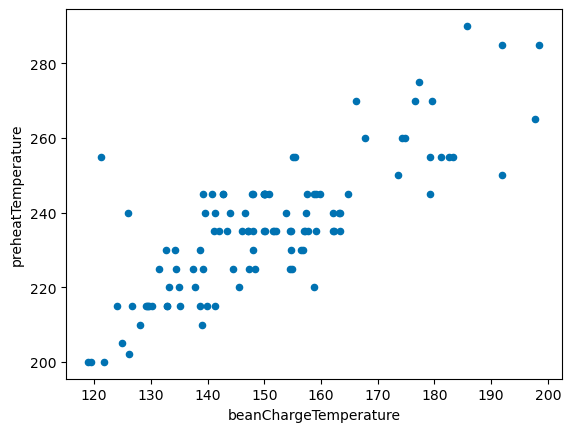

In [18]:
#####################    playing around with plot types and early observations as I learn
## Plot points_df  ##
#####################
# Bar Plot example
#point_df.plot.bar(x='roastName', y=["preheatTemperature","beanDropTemperature"])

# Box Plot example
#point_df['ibtsTurningPointTemp'].plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)

# PH to yellowing pt relation
point_df.plot.scatter(x='yellowPointTime', y='drumChargeTemperature')  #['indexYellowingStart', 'indexFirstCrackStart', 'roastEndIndex'])
# shows errors in recording actualy preheat temp (or charging too early)
point_df.plot.scatter(x='beanChargeTemperature', y='preheatTemperature') 

# difference between thermal probes
#point_df.plot.scatter(x= 'beanChargeTemperature', y='drumChargeTemperature')  
plt.show()

# colored scatter example
#iFCS = point_df['indexFirstCrackStart']/120
#plt.scatter(iFCS, point_df['drumChargeTemperature'], 
#            s=point_df['drumDropTemperature'], c=point_df['roastEndIndex'], alpha=0.5)
#plt.xlabel('First Crack Start (mins)')
#plt.ylabel('Preheat Temp (℃)')
#plt.show()

# Scatter Matrix 
from pandas.plotting import scatter_matrix 

# selecting  numerical features # Edit these to plot something differetn
features = [ 'drumChargeTemperature', 'ibtsTurningPointTemp', 'turningPointTime', 'yellowPointTime',
            'indexFirstCrackStart', 'beanDropTemperature','totalRoastTime','weightLostPercent',
            'Drop-ChargeDeltaTemp', 'ambient', 'time/temp']
sm = scatter_matrix(point_df[features], range_padding= .5, alpha = .9, figsize=(15,15))
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.get_yaxis().set_label_coords(-1,0.5) for s in sm.reshape(-1)]

plt.show() 

In [22]:
######################################################
## finding outliers and specific roasts from above  ##
######################################################

display (df.loc[(df.weightLostPercent > 20),['roastName', 'weightGreen', 'weightRoasted', 'weightLostPercent']])

# call out roasts in one region  #TO DO - make a region review variable
print ('\n kenyans')
for n in point_df.roastName:
    if n.__contains__("kenya") or n.__contains__("Kenya"):
        print (n)
        
# review roasts that are less than 8 mins - suspect that they are just roasting goof ups
print ('\n short roasts, less than 8 min')   
display (point_df.loc[(point_df.totalRoastTime) < 8,['roastName','totalRoastTime']])

# review roasts where the pre-heat temp was recorded to anything higher than I ever PH at
print ('\n high pre-heat outliers')   
display (point_df.loc[(point_df.preheatTemperature) > 290,['roastName', 'preheatTemperature','drumChargeTemperature']])

# sometimes the drumChargeTemperature is reading something lower than what the pre-heat was set at
# either because you started the roast without hitting the proper pre-heat or some other error
print ('\n charge temp  < 205 C')
display (point_df.loc[(point_df.drumChargeTemperature) < 205,['roastName', 'preheatTemperature','drumChargeTemperature']])

# Looking for errors or bad roasts with low drop temps
print ('\n low bean drop temp C')   #TO DO I need to be more specific at what/why I'm calling these outliners
display (point_df.loc[(point_df.drumDropTemperature) < 185,['roastName','drumDropTemperature','beanDropTemperature', 'totalRoastTime',
                                                            'comments', ]])

Empty DataFrame
Columns: [roastName, weightGreen, weightRoasted, weightLostPercent]
Index: []


 kenyans
#13 Kenya Nyeri Githiru AA
# 25 Kenya Mix 350/140
# 25 Kenya Mix 350/140
#33 Kenya Gakuyu-Ini AA
#34 Kenya - Soak and watch
#35 Kenya no soak - FC stall, balls
#37 Kenya - fast start. always stalls
#44 Kenya - Rao suggestion
#45 Kenya Rao's with little to no fan. still crashed 40s after FC
#48 Kenya - dip to fix crash
#49 Kenya playback
#50 Kenya Recipie off 48

 short roasts, less than 8 min


roastName  totalRoastTime
93  #100 Columbia Hulia double ferment - heater er...        6.233333


 high pre-heat outliers


Empty DataFrame
Columns: [roastName, preheatTemperature, drumChargeTemperature]
Index: []


 charge temp  < 205 C


roastName  preheatTemperature  \
9             #11 Ethiopia Agaro Nano Challa w/ Rob                 200   
16                        #21 Ethiopia Genji Challa                 202   
21                           # 25 Kenya Mix 350/140                 200   
22                           # 25 Kenya Mix 350/140                 200   
25                       #29 Genji Challa DP - Good                 245   
95  #102 Columbia Huila Double Ferment -  hot night                 255   

    drumChargeTemperature  
9                   201.5  
16                  201.9  
21                  202.7  
22                  203.3  
25                  194.7  
95                   81.4


 low bean drop temp C


roastName  drumDropTemperature  \
93  #100 Columbia Hulia double ferment - heater er...                179.0   

    beanDropTemperature  totalRoastTime comments  
93                168.6        6.233333      NaN